<a href="https://colab.research.google.com/github/Sergeichik/MLDM-2023/blob/main/02-linear-regression/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [198]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

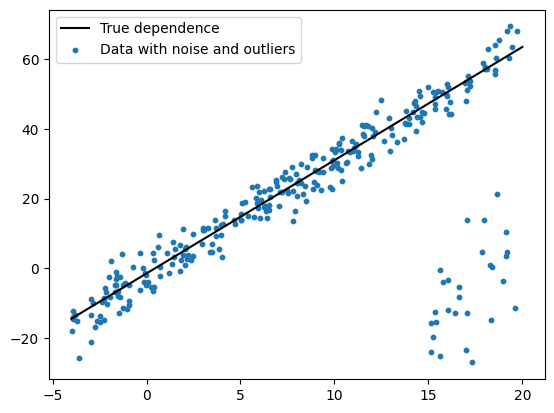

In [199]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

(300, 1)
(300,)
(2,)


100%|██████████| 1000/1000 [00:00<00:00, 17069.17it/s]


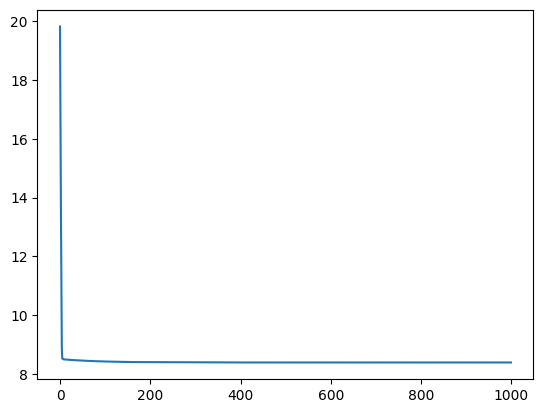

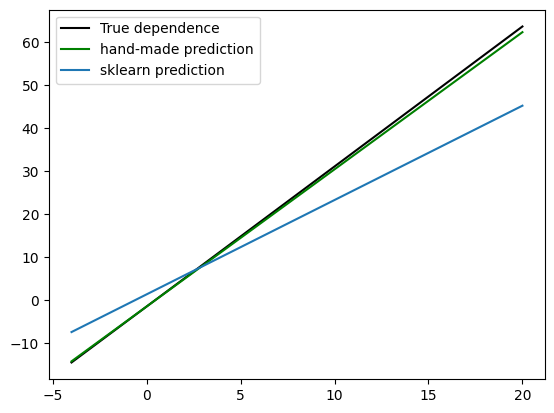

In [200]:
from sklearn.linear_model import LinearRegression
from tqdm import trange, tqdm
X_new = np.concatenate([X, np.ones(shape=(X.shape[0], 1))], axis=1)
w = np.zeros(dtype=float, shape=X_new.shape[1])
print(X.shape)
print(y.shape)
print(w.shape)


loss_values = [] # a list to keep track of how the loss value changes
learning_rate = 0.1
def mae_loss(X, y, w):
  return (np.abs(y - X @ w)).mean()

def mse_loss(X, y, w):
  return ((y - X @ w)**2).mean()
# Training loop
for _ in trange(1000):
  # Calculation of the gradient of MAE with respect to w:
  gradient = -(1./X_new.shape[0])*(np.sign(y - X_new@w)@X_new)

  # Automatic checks
  assert gradient.shape == w.shape
  assert (
      np.abs(y - X_new @ w).mean() >
      np.abs(y - X_new @ (w - 1.e-6 * gradient)).mean()
  )

  # Gradient descent step
  w -= learning_rate * gradient

  # Calculate and record the new loss value
  loss_values.append(
      mae_loss(X_new, y, w)
  )

# Plotting the evolution of loss values
plt.plot(loss_values);
plt.show()
model = LinearRegression()
model.fit(X, y)
learning_function = lambda x: w[0] * x + w[1]
x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.plot(x, learning_function(x), c='green', label='hand-made prediction')
plt.plot(x, model.predict(x[:,None]), label='sklearn prediction')

plt.legend();

#We may observe that the metrics which was used for this specific task results in much better description than the metrics that is used in sklearn (probably there is used MSE metrics)

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [201]:
from sklearn.base import BaseEstimator, RegressorMixin

In [230]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin): # inherit base class
    def __init__(self,
                 batch_size: int=10,
                 lr: float=1e-3,
                 n_iters: int=10,
                 loss_func: str='mse' ) -> None:
        self.batch_size = batch_size
        self.lr = lr
        self.n_iters = n_iters
        self.loss_func = loss_func
        self.loss_history = np.zeros(self.n_iters)

    def fit(self, X, y):
        def calculate_grad_loss_mae(X, y, w):
          return -(1./X.shape[0]) * (np.sign(y - X@w)) @ X, mae_loss(X, y, w)
        def calculate_grad_loss_mse(X, y, w):
          return ((1./X.shape[0])*(2.)*(X@w - y)@X), mse_loss(X, y, w)
        if self.loss_func == 'mae':
            calculate_grad_loss = calculate_grad_loss_mae
        elif self.loss_func == 'mse':
            calculate_grad_loss = calculate_grad_loss_mse
        X_new = np.concatenate([X, np.zeros(shape=(X.shape[0], 1))], axis=1)
        w = np.zeros(X_new.shape[1])

        for epoch in range(self.n_iters):
            gradient, loss = calculate_grad_loss(X_new, y, w)
            w -= gradient * self.lr
            self.loss_history[epoch] = loss
        self.w = w
        return self
    def predict(self, X):
      X_new = np.concatenate([X, np.zeros(shape=(X.shape[0], 1))], axis=1)
      return X_new @ self.w
    def fit_predict(self, X, y):
      self.fit(X, y)
      return self.predict(X)

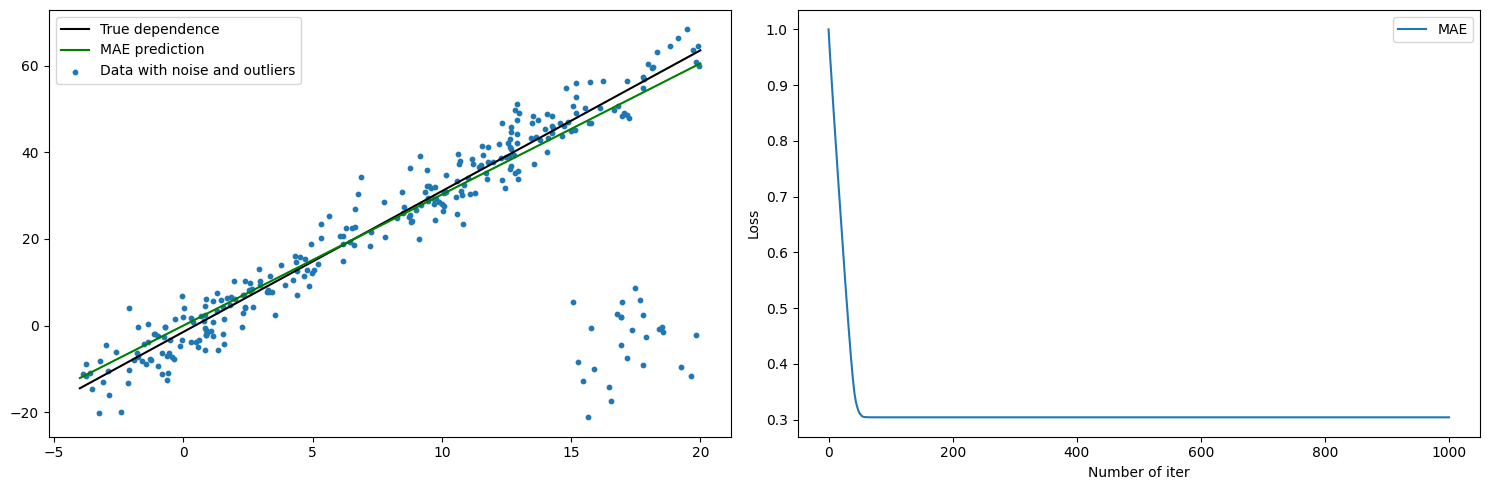

In [236]:
model = LinearRergessionSGD(lr = 1e-2, n_iters = 1000, loss_func = 'mae')
model.fit(X, y)
MAE_function = lambda x: model.w[0] * x + model.w[1]
X, y = generate_dataset()
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(*limits, 101)
axs[0].plot(x, true_function(x), c='black', label='True dependence')
axs[0].plot(x, model.predict(x[:, None]), c='green', label='MAE prediction')
axs[0].scatter(X, y, s=10, label='Data with noise and outliers')
axs[0].legend();

axs[1].plot(np.linspace(0, 1000, 1000), model.loss_history/model.loss_history[0], label='MAE')
axs[1].set_xlabel('Number of iter')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()
